In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
model = tf.keras.models.load_model('drive/MyDrive/single-person-pose-estimation/trained_models/first_Adam_RME')

/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:305: UserWarning: model.hourglass is not loaded, but a Lambda layer uses it. It may cause errors.
  'function_type')


In [ ]:
image = tf.io.decode_image(tf.io.read_file("drive/MyDrive/single-person-pose-estimation/demo pics/yoga.jpg"), channels=3, dtype=tf.dtypes.float32)
image

<tf.Tensor: shape=(581, 670, 3), dtype=float32, numpy=
array([[[0.26666668, 0.2392157 , 0.20000002],
        [0.26666668, 0.2392157 , 0.20000002],
        [0.27058825, 0.24313727, 0.20392159],
        ...,
        [0.4784314 , 0.46274513, 0.427451  ],
        [0.47450984, 0.45882356, 0.42352945],
        [0.47450984, 0.45882356, 0.42352945]],

       [[0.26666668, 0.2392157 , 0.20000002],
        [0.26666668, 0.2392157 , 0.20000002],
        [0.27058825, 0.24313727, 0.20392159],
        ...,
        [0.4784314 , 0.46274513, 0.427451  ],
        [0.47450984, 0.45882356, 0.42352945],
        [0.47450984, 0.45882356, 0.42352945]],

       [[0.26666668, 0.2392157 , 0.20000002],
        [0.27058825, 0.24313727, 0.20392159],
        [0.27058825, 0.24313727, 0.20392159],
        ...,
        [0.48627454, 0.45882356, 0.427451  ],
        [0.48627454, 0.45882356, 0.427451  ],
        [0.48627454, 0.45882356, 0.427451  ]],

       ...,

       [[0.61960787, 0.5764706 , 0.5058824 ],
        [0.62

In [ ]:
image = tf.io.decode_image(tf.io.read_file("drive/MyDrive/single-person-pose-estimation/demo pics/yoga.jpg"), channels=3, dtype=tf.dtypes.float32)
image = tf.image.resize(image, (256, 256))
image = tf.expand_dims(image, axis = 0) #cause when train the model take in (batch_size, width, height, channels)

In [ ]:
prediction = model.predict(image)
heatmaps = tf.image.resize(prediction[-1][0], (256, 256)) #last stack prediction & resize to 256x256

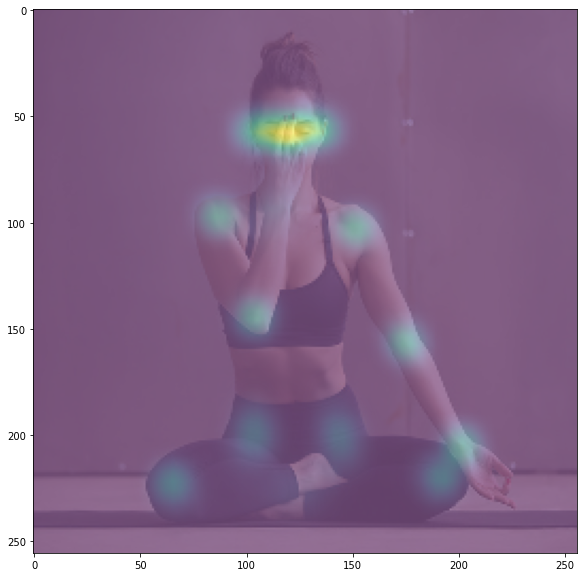

In [ ]:
plt.figure(figsize=(10,10))  
plt.imshow(image[0], cmap = 'gray', alpha = 0.5)
plt.imshow(tf.reduce_sum(heatmaps, axis = -1), alpha = 0.5)

In [ ]:
heatmaps.get_shape()

TensorShape([256, 256, 17])

In [ ]:
def find_max_coords(heatmaps):
  flatten_heatmaps = tf.reshape(heatmaps, (64*64, 17))
  indices = tf.math.argmax(flatten_heatmaps, axis = 0)
  x = indices%64
  y = indices//64
  return x, y

In [ ]:
x, y = find_max_coords(prediction[-1][0])

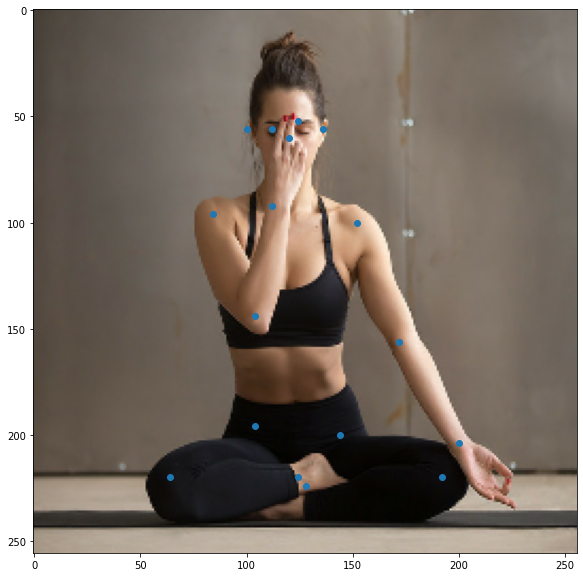

In [ ]:
plt.figure(figsize=(10,10))  
plt.imshow(image[0])
plt.scatter(x.numpy()*256/64, y.numpy()*256/64)

In [ ]:
joints = np.array([
                    [16, 14],
                    [14, 12],
                    [17, 15],
                    [15, 13],
                    [12, 13],
                    [6, 12],
                    [7, 13],
                    [6, 7],
                    [6, 8],
                    [7, 9],
                    [8, 10],
                    [9, 11],
                    [2, 3],
                    [1, 2],
                    [1, 3],
                    [2, 4],
                    [3, 5],
                    [4, 6],
                    [5, 7]]) - 1
joints

array([[15, 13],
       [13, 11],
       [16, 14],
       [14, 12],
       [11, 12],
       [ 5, 11],
       [ 6, 12],
       [ 5,  6],
       [ 5,  7],
       [ 6,  8],
       [ 7,  9],
       [ 8, 10],
       [ 1,  2],
       [ 0,  1],
       [ 0,  2],
       [ 1,  3],
       [ 2,  4],
       [ 3,  5],
       [ 4,  6]])

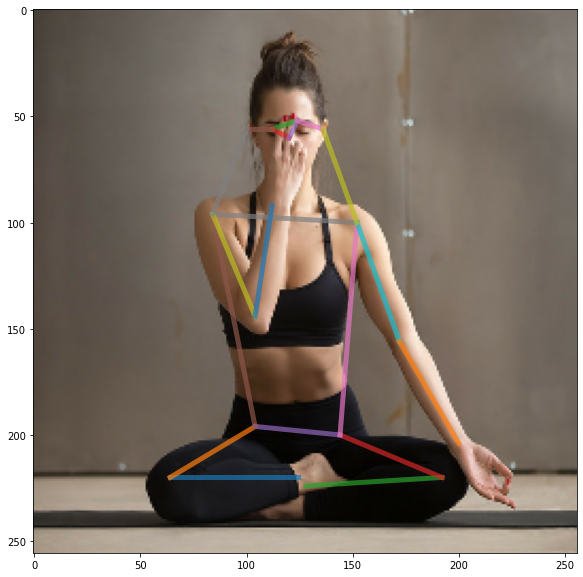

In [ ]:
plt.figure(figsize=(10,10))  
plt.imshow(image[0])
for joint in joints:
  joint1 = joint[0]
  joint2 = joint[1]
  x_values = np.array([x[joint1], x[joint2]]) * 256/64
  y_values = np.array([y[joint1], y[joint2]]) * 256/64
  plt.plot(x_values, 
            y_values, linewidth = 5, alpha = 0.7)

In [2]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, image_data):
  data = eval_js('stream_frame("{}", "{}")'.format(label, image_data))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"]) # numpy, shape (480, 640, 3)
    

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)


    # get face bounding box for overlay
    bbox_array = cv2.line(bbox_array, (0,0), (240, 320), color = (0, 255, 0))

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

In [29]:
image = cv2.imread('drive/MyDrive/single-person-pose-estimation/demo pics/yoga.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image 

array([[[ 70,  61,  52],
        [ 70,  61,  52],
        [ 70,  61,  52],
        ...,
        [124, 117, 111],
        [124, 117, 111],
        [124, 117, 111]],

       [[ 70,  61,  52],
        [ 70,  61,  52],
        [ 70,  61,  52],
        ...,
        [124, 117, 111],
        [124, 117, 111],
        [124, 117, 111]],

       [[ 70,  61,  52],
        [ 70,  61,  52],
        [ 71,  62,  53],
        ...,
        [124, 117, 111],
        [124, 117, 111],
        [124, 117, 111]],

       ...,

       [[160, 147, 131],
        [160, 147, 131],
        [161, 148, 132],
        ...,
        [175, 159, 144],
        [171, 155, 140],
        [169, 153, 140]],

       [[161, 148, 132],
        [161, 148, 132],
        [161, 148, 132],
        ...,
        [182, 166, 151],
        [175, 159, 144],
        [170, 154, 141]],

       [[168, 155, 139],
        [168, 155, 139],
        [168, 155, 139],
        ...,
        [184, 168, 153],
        [176, 160, 145],
        [170, 154, 141]]

In [28]:
#tensor = tf.image.resize(image, (256, 256))
tensor = tf.image.convert_image_dtype(image, dtype=tf.float32)
tensor

<tf.Tensor: shape=(581, 670, 3), dtype=float32, numpy=
array([[[0.27450982, 0.2392157 , 0.20392159],
        [0.27450982, 0.2392157 , 0.20392159],
        [0.27450982, 0.2392157 , 0.20392159],
        ...,
        [0.48627454, 0.45882356, 0.43529415],
        [0.48627454, 0.45882356, 0.43529415],
        [0.48627454, 0.45882356, 0.43529415]],

       [[0.27450982, 0.2392157 , 0.20392159],
        [0.27450982, 0.2392157 , 0.20392159],
        [0.27450982, 0.2392157 , 0.20392159],
        ...,
        [0.48627454, 0.45882356, 0.43529415],
        [0.48627454, 0.45882356, 0.43529415],
        [0.48627454, 0.45882356, 0.43529415]],

       [[0.27450982, 0.2392157 , 0.20392159],
        [0.27450982, 0.2392157 , 0.20392159],
        [0.2784314 , 0.24313727, 0.20784315],
        ...,
        [0.48627454, 0.45882356, 0.43529415],
        [0.48627454, 0.45882356, 0.43529415],
        [0.48627454, 0.45882356, 0.43529415]],

       ...,

       [[0.627451  , 0.5764706 , 0.5137255 ],
        [0.62

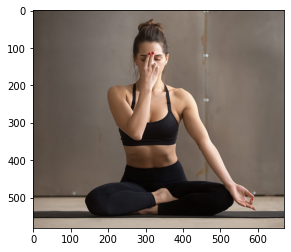

In [25]:
plt.imshow(image)